In [38]:
import os; os.environ['OPENBLAS_NUM_THREADS']='1'

In [57]:
import numpy as np
import pandas as pd
import implicit
from scipy.sparse import coo_matrix
from implicit.evaluation import mean_average_precision_at_k

In [25]:
transactions_df = pd.read_csv("data/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
customers_df = pd.read_csv('data/h-and-m-personalized-fashion-recommendations/customers.csv')
articles_df = pd.read_csv('data/h-and-m-personalized-fashion-recommendations/articles.csv')

In [26]:
start_date = pd.to_datetime('2020-07-01')
end_date = pd.to_datetime('2020-09-22')

# Filter transactions by date
transactions_df.t_dat = pd.to_datetime(transactions_df.t_dat)
transactions_df = transactions_df.loc[transactions_df.t_dat >= start_date]
transactions_df = transactions_df.loc[transactions_df.t_dat < end_date]


In [27]:
pd.options.display.max_rows = 50
customers_df

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [28]:
customers_df.shape[0] - customers_df['customer_id'].nunique()

0

In [29]:
data_postal = customers_df.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303,42874,39886,118281,114377,118002
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac...,261,109,104,261,261,260
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c...,159,90,88,159,159,158
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5...,157,55,54,157,156,156
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee...,156,42,41,156,156,155


In [30]:
customers_df[customers_df['postal_code']=='2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'].head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
11,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,NaN,NaN,ACTIVE,NONE,31.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
14,0000ae1bbb25e04bdc7e35f718e852adfb3fbb72ef38b3...,1.0,1.0,ACTIVE,Regularly,29.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


In [58]:
import seaborn as sns
from matplotlib import pyplot as plt

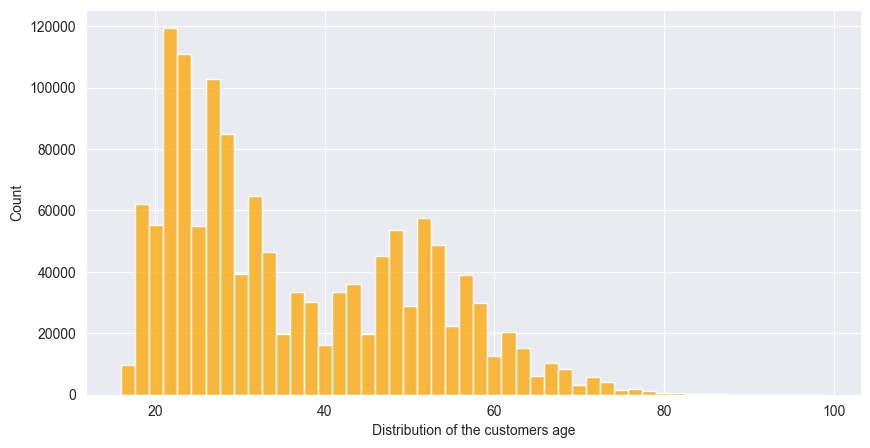

In [16]:

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_df, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

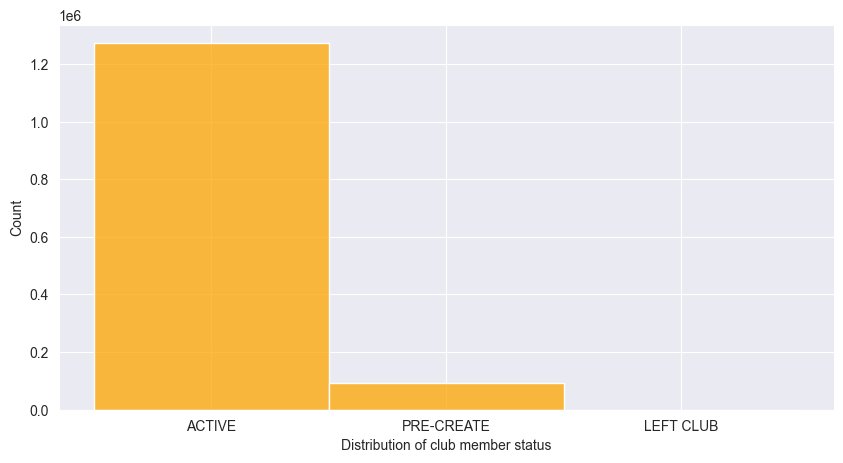

In [17]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers_df, x='club_member_status', color='orange')
ax.set_xlabel('Distribution of club member status')
plt.show()

In [20]:
customers_df['fashion_news_frequency'].head()

0         None
1         None
2         None
3         None
4    Regularly
Name: fashion_news_frequency, dtype: object

In [21]:
customers_df['fashion_news_frequency'].value_counts()

fashion_news_frequency
None         893722
Regularly    477416
Monthly         842
Name: count, dtype: int64

In [19]:
customers_df.loc[~customers_df['fashion_news_frequency'].isin(['Regularly', 'Monthly']), 'fashion_news_frequency'] = 'None'
customers_df['fashion_news_frequency'].unique()

array(['None', 'Regularly', 'Monthly'], dtype=object)

In [22]:
pie_data = customers_df[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()

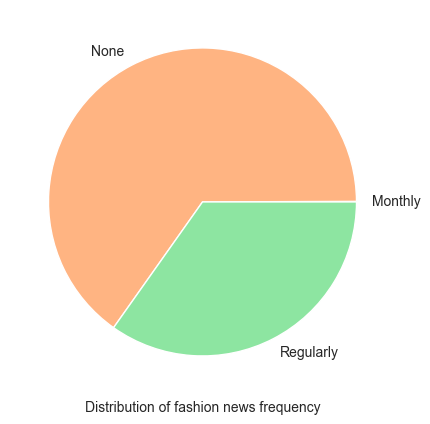

In [23]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
# ax = sns.histplot(data=customers, x='fashion_news_frequency', color='orange')
# ax = sns.pie(data=customers, x='fashion_news_frequency', color='orange')
colors = sns.color_palette('pastel')
ax.pie(pie_data.customer_id, labels=pie_data.index, colors = colors)
ax.set_facecolor('lightgrey')
ax.set_xlabel('Distribution of fashion news frequency')
plt.show()

In [24]:
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
28401361,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,0.013542,2
28401362,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,849487005,0.042356,2
28401363,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,772659001,0.023712,2
28401364,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.042356,2
28401365,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.042356,2


In [26]:
pd.set_option('display.float_format', '{:.4f}'.format)
transactions_df.describe()['price']

count   3354097.0000
mean          0.0272
min           0.0001
25%           0.0155
50%           0.0254
75%           0.0339
max           0.5068
std           0.0185
Name: price, dtype: float64

In [27]:
transactions_byid = transactions_df.groupby('customer_id').count()

In [28]:
transactions_byid.sort_values(by='price', ascending=False)['price'][:10]

customer_id
b637a3e7d8b0caa947aaefd609b8d84a9ee962cf0a52a51bac507ffc2bf1b741    316
4308983955108b3af43ec57f0557211e44462a5633238351fff14c8b51f16093    299
a3ab708684132c6bbd3dad7aa41f9b9c7d1c95d7d5cb1a3a052905191e858566    294
67931690bdf18d2e328854ae772cd5ce2505fdc11164693998b13e706db0bb56    259
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    246
4043fdbe22eb397206dabf520d2d88651179724ac19ccf6e69efadfd3da530b6    236
9150085d4efd2dcfdb954180217ce6c2b6e3399963fb19daef2cf6078a77903e    235
4de6988c4971cfc0c6910a85a54fa8d6fb11be64b87b98c46b73821d7db07ce7    231
d80ed4ababfa96812e22b911629e6bcbf5093769051ea447e2b696ac98a3dae9    225
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    222
Name: price, dtype: int64

In [30]:
articles_for_merge = articles_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]

In [31]:
articles_for_merge = transactions_df[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

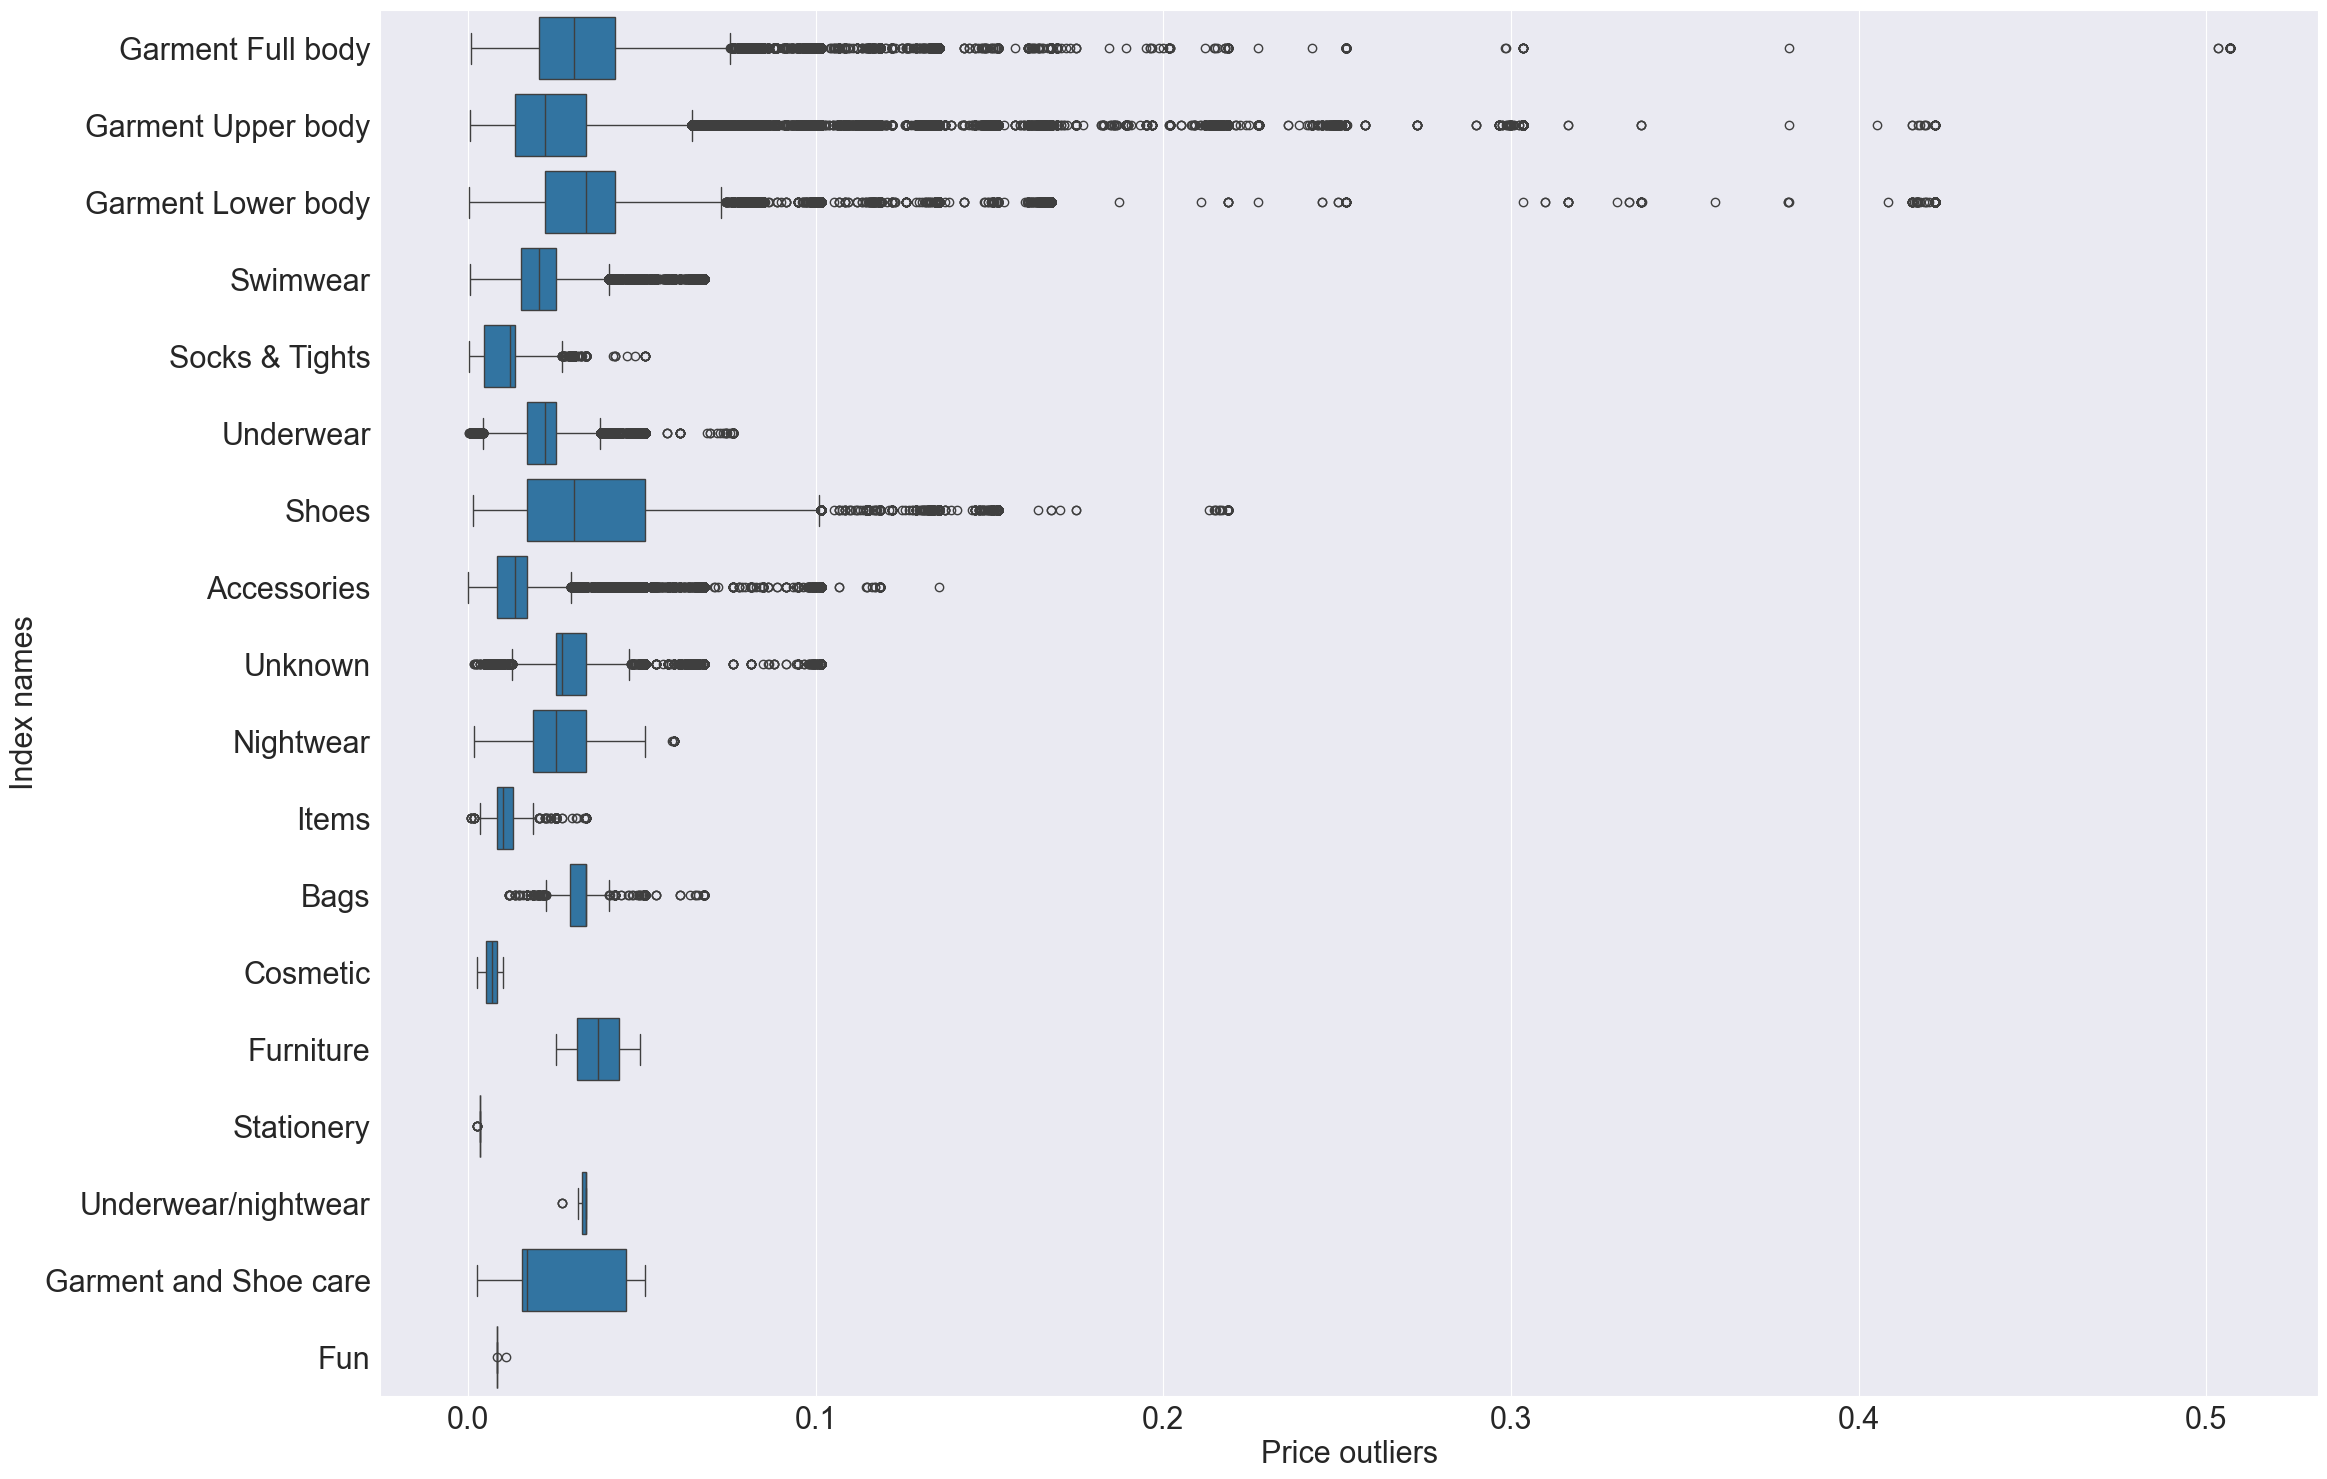

In [32]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,18))
ax = sns.boxplot(data=articles_for_merge, x='price', y='product_group_name')
ax.set_xlabel('Price outliers', fontsize=22)
ax.set_ylabel('Index names', fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

plt.show()

In [33]:
articles_for_merge.head()

,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,0.0135,2020-07-01,PIXI TSHIRT DRESS,Dress,Garment Full body,Ladieswear
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,849487005,0.0424,2020-07-01,Seb overshirt,Jacket,Garment Upper body,Ladieswear
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,772659001,0.0237,2020-07-01,Ruby shorts,Shorts,Garment Lower body,Ladieswear
3,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.0424,2020-07-01,Durham joggers(1),Trousers,Garment Lower body,Ladieswear
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,804732004,0.0424,2020-07-01,Durham joggers(1),Trousers,Garment Lower body,Ladieswear


In [34]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


# Benchmark Model : Matrix Factorization - ALS 

In [35]:
ALL_USERS = customers_df['customer_id'].unique().tolist()
ALL_ITEMS = articles_df['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

transactions_df['user_id'] = transactions_df['customer_id'].map(user_map)
transactions_df['item_id'] = transactions_df['article_id'].map(item_map)

## sparse matrix

In [36]:
row = transactions_df['user_id'].values
col = transactions_df['item_id'].values
data = np.ones(transactions_df.shape[0])
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

<1371980x105542 sparse matrix of type '<class 'numpy.float64'>'
	with 3354097 stored elements in COOrdinate format>

In [37]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=10, iterations=2)
model.fit(coo_train)

/usr/local/anaconda3/envs/inflab/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/usr/local/anaconda3/envs/inflab/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.18769121170043945 seconds
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 12.6 s, sys: 1.76 s, total: 14.3 s
Wall time: 8.4 s


In [39]:
def to_user_item_coo(df):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo


def split_data(df, validation_days=7):
    """ Split a pandas dataframe into training and validation data, using <<validation_days>>
    """
    validation_cut = df['t_dat'].max() - pd.Timedelta(validation_days)

    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

def get_val_matrices(df, validation_days=7):
    """ Split into training and validation and create various matrices
        
        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_val:  validation data in CSR sparse format and as (users x items)
    
    """
    df_train, df_val = split_data(df, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    
    # The MAPK by implicit doesn't allow to calculate allowing repeated items, which is the case.
    # TODO: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [43]:
matrices = get_val_matrices(transactions_df)

In [61]:
%%time
best_map12 = 0
for factors in [200]:
    for iterations in [20]:
        for regularization in [0.01]:
            map12 = validate(matrices, factors, iterations, regularization, show_progress=True)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

/usr/local/anaconda3/envs/inflab/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.3585658073425293 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10119 [00:00<?, ?it/s]

Factors: 200 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00639
Best MAP@12 found. Updating: {'factors': 200, 'iterations': 20, 'regularization': 0.01}
CPU times: user 9min 29s, sys: 1min 9s, total: 10min 38s
Wall time: 2min 38s


# Factorization Machine

In [31]:
def get_most_bought_articles(data, num_articles=5):
    # Create dataframe that contains the number of times each article has been bought
    articles_counts = data[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
    articles_counts = articles_counts.sort_values(by='count', ascending=False)
        
    most_bought_articles = articles_counts.loc[articles_counts['count'] >= num_articles]['article_id'].values
    
    return most_bought_articles

In [32]:
transactions_df.t_dat.max()

Timestamp('2020-09-21 00:00:00')

- training data는 직전 7일을 제외하고 구성하였음

In [33]:
start_date = pd.to_datetime('2020-07-01')
end_date = pd.to_datetime('2020-09-22') - pd.Timedelta(7,'days')

# Filter transactions by date
transactions_df.t_dat = pd.to_datetime(transactions_df.t_dat)
transactions_df = transactions_df.loc[transactions_df.t_dat >= start_date]
transactions_df = transactions_df.loc[transactions_df.t_dat < end_date]

# Get articles with at least num_articles purchases and remove the rest from the
# transactions
most_bought_articles = get_most_bought_articles(transactions_df, num_articles=100)
transactions_df = transactions_df.loc[transactions_df.article_id.isin(most_bought_articles)]

article_ids = articles_df['article_id'].values
customer_ids = customers_df['customer_id'].values

num_articles = len(article_ids)
num_customers = len(customer_ids)
# Create dictionaries with mapping keys
articles_id_to_idx = dict(zip(article_ids, range(num_articles)))
customers_id_to_idx = dict(zip(customer_ids, range(num_customers)))

train_df = transactions_df.copy()
train_df = train_df[['customer_id', 'article_id']]

num_transactions = train_df.shape[0]

train_df['bought'] = np.ones(num_transactions)

train_df

,customer_id,article_id,bought
28401361,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,1.0
28401368,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,824194004,1.0
28401370,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,869796001,1.0
28401371,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,562498011,1.0
28401374,000ce5da167c6c8dfaea6dfc4b59a5ea3217630ec36cfc...,559616013,1.0
...,...,...,...
31521954,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,509091057,1.0
31521955,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,859737002,1.0
31521956,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,573085028,1.0
31521957,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,745686008,1.0


- Negative Sampling

In [34]:
np.random.seed(47)

negative_data = pd.DataFrame(
    {
        'article_id': np.random.permutation(train_df.article_id.values),
        'customer_id': train_df.customer_id.values,
        'bought': np.zeros(num_transactions)
    }
)

train_df = pd.concat([train_df, negative_data])
train_df = train_df.sample(frac=1).reset_index(drop=True)

train_df

,customer_id,article_id,bought
0,842b38512d803cdcb28640b448945a66ad40a68e0ca649...,757303012,0.0
1,57eefa27ed4779d5061f783e885cb42af4c4faa90d9dd7...,851400001,0.0
2,cdf5e1b63b8ba6f85e1c7c8e5c6f7a99214525c15dd725...,824340002,0.0
3,ecbe914acaf164501d65eed0ef2b12c77178f9b2a7ec09...,853391001,0.0
4,033311dc4ed46174736a2154547ead757f45c86561942d...,854356001,1.0
...,...,...,...
5120949,ba6d697ddd55beb42597eabd77f97262841fffe0db6a97...,865594003,1.0
5120950,34794f2273000f1333ae71b0e1f7ff87b5f881b448a9e9...,859077013,0.0
5120951,e6dba0c4d64a0a0d620233e89ab61becd3a2dea6e2f96a...,825811002,0.0
5120952,8669a760b060a074d0b73251ba63c6a0389d4bdc715ce1...,851400001,1.0


### Feature Engineering

In [90]:
articles_index_group_to_index = dict(zip(articles_df.index_group_no.unique(), range(articles_df.index_group_no.nunique())))

In [91]:
articles_index_group_to_index

{1: 0, 4: 1, 3: 2, 26: 3, 2: 4}

In [111]:
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pandas as pd

def preprocess_customers_df(customers_df, transactions_df):
    # Check if active and have club member status
    customers_df[['Active']] = customers_df[['Active']].fillna(value=0) 
    customers_df['club_member_status'] = customers_df['club_member_status'] == 'ACTIVE'

    # 특정한 우편 번호에 대해서는 Binary Encoding을 수행한다.
    customers_df['common_postal_code'] = customers_df['postal_code'] == '2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'

    # 나이가 없는 user에 대하여 빈 값을 사용한다.
    customers_df[['age']] = customers_df[['age']].fillna(value=customers_df['age'].mean())

    # 사용하지 않는 컬럼을 drop 한다.
    customers_df = customers_df.drop(['FN', 'fashion_news_frequency', 'postal_code'], axis=1)

    # Replace boolean with 1/0
    customers_df['club_member_status'] = customers_df['club_member_status'].astype(int)
    customers_df['common_postal_code'] = customers_df['common_postal_code'].astype(int)
    
    customers_df = customers_df.merge(transactions_df[['customer_id', 'article_id']], on="customer_id")
    customers_df = customers_df.merge(articles_df[['article_id','index_group_no']], on="article_id") # 추가한 Articles Feature
    return customers_df

def create_sparse_matrix(transactions_df, articles_df, customers_df, articles_to_idx, customers_to_idx): 
    customers_df = preprocess_customers_df(customers_df, transactions_df)
    
    # Create one hot encoded customers matrix
    cols = np.array([customers_to_idx[customer] for customer in customers_df['customer_id']])
    rows = np.array(list(range(0, len(customers_df))))
    data = np.ones(len(rows))
    csr_customers = csr_matrix((data, (rows, cols)), shape=(len(rows), len(customers_to_idx)))
    
    # Create one hot encoded bought articles matrix
    rows = np.array(list(range(0, len(customers_df))))
    cols = np.array([articles_to_idx[article] for article in customers_df['article_id']])
    data = np.ones(len(rows))
    csr_articles = csr_matrix((data, (rows, cols)), shape=(len(rows), len(articles_to_idx)))
    
    # Create CSR matrix for article features
    rows = np.array(list(range(0, len(customers_df))))
    cols = np.array([articles_index_group_to_index[article_group_no] for article_group_no in customers_df['index_group_no']])
    data = np.ones(len(rows))
    csr_articles_feature = csr_matrix((data, (rows, cols)), shape=(len(rows), len(articles_index_group_to_index)))

    # Concatenate matrices in CSR format
    # sparse_matrix = hstack((csr_customers, csr_articles), format='csr')
    sparse_matrix = hstack((csr_customers, csr_articles, csr_articles_feature), format='csr')
    # Age
    sparse_matrix = hstack((sparse_matrix, customers_df['age'].values[:,None]), format='csr')
    # Active
    sparse_matrix = hstack((sparse_matrix, customers_df['Active'].values[:,None]), format='csr')
    # Club member status
    sparse_matrix = hstack((sparse_matrix, customers_df['club_member_status'].values[:,None]), format='csr')
    # Common postal code
    sparse_matrix = hstack((sparse_matrix, customers_df['common_postal_code'].values[:,None]), format='csr')
    # Average price spent
    # sparse_matrix = hstack((sparse_matrix, customers_df['price'].values[:,None]))
    
    return sparse_matrix

In [112]:
from scipy import sparse

sparse_matrix = create_sparse_matrix(train_df, articles_df, customers_df, articles_id_to_idx, customers_id_to_idx)

In [113]:
sparse_matrix

<5120954x1477531 sparse matrix of type '<class 'numpy.float64'>'
	with 22851812 stored elements in Compressed Sparse Row format>

In [114]:
from tqdm import tqdm
from numba import njit
import numba as nb

# @njit
# def log_loss(y_true, y_pred):
#     epsilon = 1e-15
#     # y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
#     y_pred = 1- epsilon if y_pred >= 1 else y_pred
#     y_pred = epsilon if y_pred <= 0 else y_pred
#     loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
#     return loss

# @njit
# def log_loss(y_true, y_pred):
#     epsilon = 1e-15
#     #y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
#     if y_pred < epsilon:
#         y_pred = epsilon
#     elif y_pred > 1-epsilon:
#         y_pred = 1-epsilon
#     # Compute binary cross-entropy
#     loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
#     
#     return loss
@njit
def log_loss(bought, pred):
    # Using the log loss prevents the exploiting gradient problem
    return np.log(np.exp(-pred * bought) + 1.0)
# 
# @njit
# def log_loss(y,yHat):
#     epsilon = 1e-15
#     if yHat < epsilon:
#         yHat = epsilon
#     elif yHat > 1-epsilon:
#         yHat = 1-epsilon
#     if y == 1:
#         return -np.log(yHat)
#     else:
#         return -np.log(1 - yHat)

# @njit
# def log_loss(y_true, y_pred):
#     epsilon = 1e-15
#     y_true = 1- epsilon if y_true == 1 else epsilon
#     phat = 1/(np.exp(-y_pred) + 1.0)
#     return y_true * np.log(phat) + (1 - y_true) * np.log(1 - phat)


@njit
def predict_single(data, indices, indptr, i, latent_factors, w0, w, V):
    # The sum of the interactions will be saved so that it can be used later on
    sum_factors = np.zeros(latent_factors)
    summed_squared = np.zeros(latent_factors)

    # Initialize prediction with w0
    prediction = w0

    # Linear product w * x
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        prediction += w[feature] * data[index]

    # Interactions product
    for factor in range(latent_factors):
        # squared_sum = 0

        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            product = V[factor, feature] * data[index]
            sum_factors[factor] += product
            summed_squared[factor] += product * product

        prediction += 0.5 * (sum_factors[factor] * sum_factors[factor] - summed_squared[factor])

    return prediction, sum_factors


@njit
def SGD(data, indices, indptr, latent_factors, w0, w, V, learning_rate, bought, reg_w, reg_v):
    loss = 0

    for i in range(len(bought)):
        prediction, sum_factors = predict_single(data, indices, indptr, i, latent_factors, w0, w, V)
        loss += log_loss(bought[i], prediction)
        loss_gradient = -bought[i] / (np.exp(bought[i] * prediction) + 1.0)

        # Update bias term
        w0 -= learning_rate * loss_gradient

        # Update features bias
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # Update latent factors
        for factor in range(latent_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = sum_factors[factor] - V[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                V[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * V[factor, feature])

        # if i % 100000 == 0:
        #    print('Loss at step ', i, ': ', loss)

    loss /= data.shape[0]

    return loss, w0, w, V


class FactorizationMachine:
    def __init__(self, transactions_matrix, bought, latent_factors):
        self.transactions_matrix = transactions_matrix
        self.bought = bought
        self.latent_factors = latent_factors

        self.n_samples, self.n_variables = self.transactions_matrix.shape

    def fit(self, n_epochs=10, learning_rate=0.001, lmbda=0.1, reg_w=0.01, reg_latent=0.01, verbose=True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda

        np.random.seed(47)
        # Initialize training variables
        self.w0 = 0

        self.reg_w = reg_w
        self.reg_latent = reg_latent

        self.w = np.random.normal(0, 1, self.n_variables)
        self.V = np.random.normal(0, scale=1 / np.sqrt(self.latent_factors),
                                  size=(self.latent_factors, self.n_variables))

        data = self.transactions_matrix.data
        indices = self.transactions_matrix.indices
        indptr = self.transactions_matrix.indptr
        bought = self.bought
        self.history_ = []
        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            loss, self.w0, self.w, self.V = SGD(
                data=data, indices=indices, indptr=indptr, latent_factors=self.latent_factors,
                w0=self.w0, w=self.w, V=self.V, learning_rate=self.learning_rate,
                bought=bought, reg_w=self.reg_w, reg_v=self.reg_latent
            )

            print(f'Loss: {loss}')
            self.history_.append(loss)

    def predict_proba(self, data):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self.predict_all_sample(data)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def predict_all_sample(self, data):
        """Predict vectorized for all samples"""
        linear_output = data * self.w
        v = self.V.T
        term = (data * v) ** 2 - (data.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis=1)
        return self.w0 + linear_output + factor_output

    def predict(self, data):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(data)[:, 1]
        return pred_proba.round().astype(np.int)

    def __plot_learning_curves__(self):
        # change default style figure and font size
        plt.rcParams['figure.figsize'] = 8, 6
        plt.rcParams['font.size'] = 12

        # one quick way to check that we've implemented
        # the gradient descent is to ensure that the loss
        # curve is steadily decreasing
        plt.plot(self.history_)
        plt.title('Loss Curve Per Iteration')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

In [115]:
fm = FactorizationMachine(transactions_matrix = sparse_matrix, bought = train_df.bought.values, latent_factors = 20)
fm.fit(learning_rate=0.001,n_epochs=20)

Epoch: 0
Loss: 0.07774194473787534
Epoch: 1
Loss: 0.07771638299828489
Epoch: 2
Loss: 0.07770744495408685
Epoch: 3
Loss: 0.07770049890550745
Epoch: 4
Loss: 0.07769502950862599
Epoch: 5
Loss: 0.07769066779162068
Epoch: 6
Loss: 0.07768715045116727
Epoch: 7
Loss: 0.07768428574896305
Epoch: 8
Loss: 0.07768193119657708
Epoch: 9
Loss: 0.07767997916214713
Epoch: 10
Loss: 0.07767834734750914
Epoch: 11
Loss: 0.07767697224941873
Epoch: 12
Loss: 0.07767580450697033
Epoch: 13
Loss: 0.07767480550066026
Epoch: 14
Loss: 0.07767394482289797
Epoch: 15
Loss: 0.07767319837762524
Epoch: 16
Loss: 0.07767254694416023
Epoch: 17
Loss: 0.07767197508732375
Epoch: 18
Loss: 0.07767147032755001
Epoch: 19
Loss: 0.07767102250634952


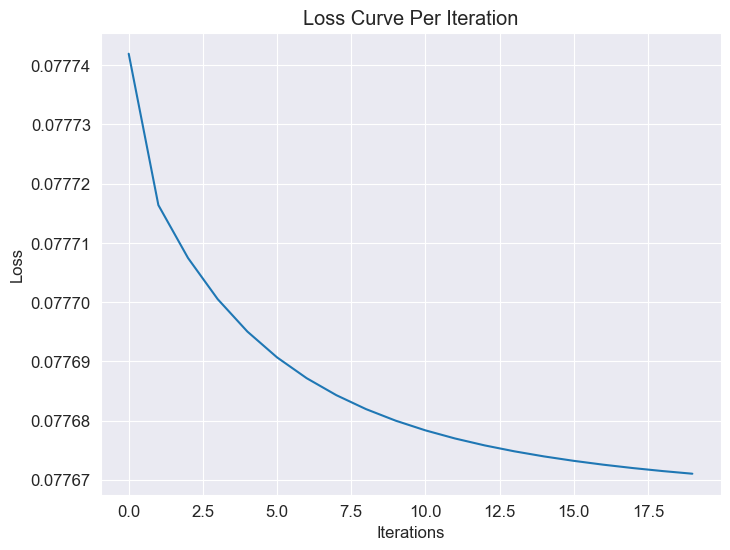

In [116]:
fm.__plot_learning_curves__()

### Predictions

In [135]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

idx_to_train_article_id = {i: article for i, article in enumerate(np.unique(train_df.article_id))}

# Generate 12 suggestions for a user-products matrix
def generate_suggestions(model, matrix, n = 12):
    proba = model.predict_proba(matrix)
    index = pd.DataFrame(proba, columns=['No', 'Yes']).sort_values('Yes', ascending = False)[0:n]['Yes'].index
    value = pd.DataFrame(proba, columns=['No', 'Yes']).sort_values('Yes', ascending = False)[0:n]['Yes'].values
    #return index, value
    return [''.join('0' + str(idx_to_train_article_id[i])) for i in index]


# Generate submission
def submission(model, res_article, res_customer, customer_matrix):
    submission = {}
    for i in tqdm(range(len(res_customer))):
        customer_id = res_customer[i]
        customer_matrix = get_user_matrix(i)
        recommendations = generate_suggestions(model, res_article, customer_matrix, n = 12)
        submission[customer_id] = ' '.join('0' + str(x) for x in recommendations)  
    return submission

def display_articles(articles):
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 3
    for i, article in enumerate(articles[0:12]):
        path = 'data/h-and-m-personalized-fashion-recommendations/images/' + article[0:3] + '/' + article + '.jpg'
        if not os.path.isfile(path):
            continue
        fig.add_subplot(rows, columns, i + 1)
        img = mpimg.imread(path)
        plt.imshow(img)
    plt.show()

def get_user_matrix(customer_id, customers_df, transactions_df):
    n_rows = len(np.unique(train_df.article_id))
    
    customers_df = preprocess_customers_df(customers_df, transactions_df)
    
    # Create CSR matrix for customers
    rows = np.arange(n_rows)
    cols = [customers_id_to_idx[customer_id]] * n_rows
    data = np.ones(n_rows)
    csr_customers = sparse.csr_matrix((data, (rows, cols)), shape=(n_rows, len(customers_id_to_idx)))

    # Create CSR matrix for articles
    rows = np.arange(n_rows)
    cols = [articles_id_to_idx[article] for article in np.unique(train_df.article_id)]
    data = np.ones(n_rows)
    csr_articles = sparse.csr_matrix((data, (rows, cols)), shape=(n_rows, len(articles_id_to_idx)))
    
    
    #todo: Create CSR matrix for article features
    rows = np.arange(n_rows)
    cols = np.array([articles_index_group_to_index[articles_df[articles_df.article_id==article].index_group_no.values[0]] for article in np.unique(train_df.article_id)])
    data = np.ones(len(rows))
    csr_articles_feature = sparse.csr_matrix((data, (rows, cols)), shape=(len(rows), len(articles_index_group_to_index)))

    customer_data = customers_df[customers_df['customer_id'] == customer_id].iloc[0]        
    
    # Concatenate matrices in CSR format
    sparse_matrix = sparse.hstack((csr_customers, csr_articles,csr_articles_feature), format='csr')
    # Age
    sparse_matrix = hstack((sparse_matrix, [[customer_data['age']]] * n_rows), format='csr')
    # Active
    sparse_matrix = hstack((sparse_matrix, [[customer_data['Active']]] * n_rows), format='csr')
    # Club member status
    sparse_matrix = hstack((sparse_matrix, [[customer_data['club_member_status']]] * n_rows), format='csr')
    # Common postal code
    sparse_matrix = hstack((sparse_matrix, [[customer_data['common_postal_code']]] * n_rows), format='csr')
    
    return sparse_matrix

In [124]:
preprocessed_customers_df = preprocess_customers_df(customers_df, transactions_df)

def get_random_recommendations(n=5):
    counter = 0
    while counter < n:
        customer_id = customers_df.iloc[np.random.randint(0, len(customers_df))]['customer_id']
        customer_info = preprocessed_customers_df.loc[preprocessed_customers_df.customer_id == customer_id]
        if len(customer_info) == 0:
            continue
        print("Customer info:")
        print(customer_info.iloc[0])
        user_matrix = get_user_matrix(customer_id, customers_df, transactions_df)
        recommendations = generate_suggestions(fm, user_matrix)
        print("Previously bought")
        display_articles(['0' + str(article) for article in train_df.loc[train_df.customer_id == customer_id]['article_id'].values])
        print("Recommendations")
        display_articles(recommendations)
        counter += 1

Customer info:
customer_id           c401b1e9ee8a15dfe4c8003f114b6e31506e6c4ea11ff3...
Active                                                              0.0
club_member_status                                                    0
age                                                                55.0
common_postal_code                                                    0
article_id                                                    685814001
index_group_no                                                        3
Name: 45742, dtype: object
Previously bought


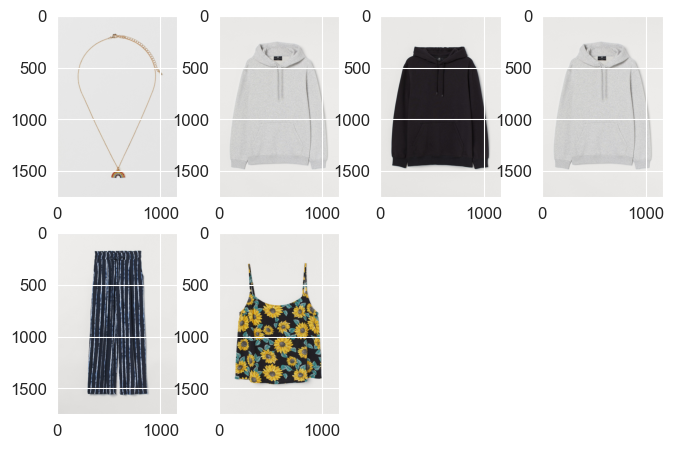

Recommendations


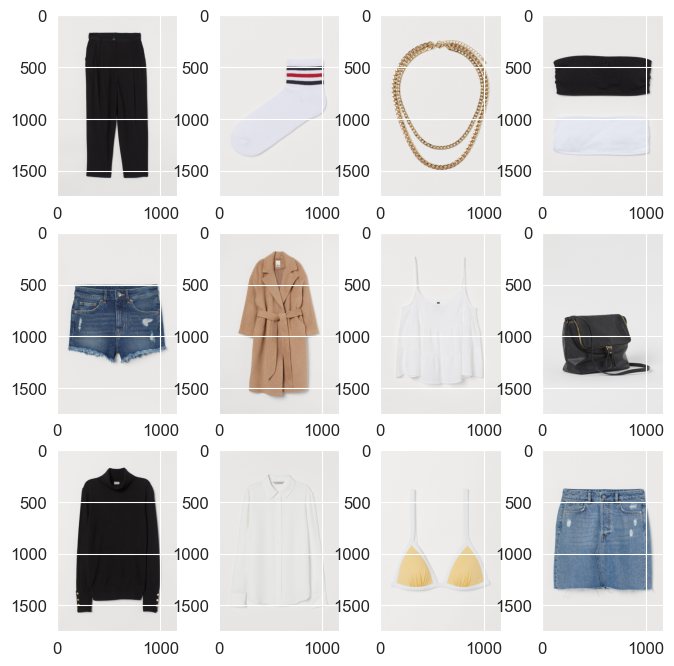

In [136]:
get_random_recommendations(n=1)

In [108]:
data = pd.read_csv("data/h-and-m-personalized-fashion-recommendations/transactions_train.csv", dtype={'article_id':str})

In [109]:
data.t_dat = pd.to_datetime(data.t_dat)

In [110]:
val_df = data.loc[data.t_dat > pd.to_datetime('2020-09-14')]


In [20]:
val_df = val_df[val_df.customer_id.isin(preprocessed_customers_df.customer_id)]

In [22]:
val_df.to_csv("validation_sm.csv",index=False)

In [27]:
val_df = val_df[['customer_id','article_id']]

In [28]:
import datetime

data["t_dat"] = pd.to_datetime(data["t_dat"])
train1 = data.loc[(data["t_dat"] >= datetime.datetime(2020,9,16)) & (data['t_dat'] < datetime.datetime(2020,9,23))]
train2 = data.loc[(data["t_dat"] >= datetime.datetime(2020,9,8)) & (data['t_dat'] < datetime.datetime(2020,9,16))]
train3 = data.loc[(data["t_dat"] >= datetime.datetime(2020,8,31)) & (data['t_dat'] < datetime.datetime(2020,9,8))]
train4 = data.loc[(data["t_dat"] >= datetime.datetime(2020,8,23)) & (data['t_dat'] < datetime.datetime(2020,8,31))]

# List of all purchases per user (has repetitions)
positive_items_per_user1 = train1.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user2 = train2.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user3 = train3.groupby(['customer_id'])['article_id'].apply(list)
positive_items_per_user4 = train4.groupby(['customer_id'])['article_id'].apply(list)

train = pd.concat([train1, train2], axis=0)
train['pop_factor'] = train['t_dat'].apply(lambda x: 1/(datetime.datetime(2020,9,23) - x).days)
popular_items_group = train.groupby(['article_id'])['pop_factor'].sum()

_, popular_items = zip(*sorted(zip(popular_items_group, popular_items_group.keys()))[::-1])

In [29]:
from collections import Counter

popular_items = list(popular_items)

def get_popularity_based_prediction(user):
    user_output = []
    if user in positive_items_per_user1.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user1[user]).most_common()}
        user_output += list(most_common_items_of_user.keys())[:12]
    if user in positive_items_per_user2.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user2[user]).most_common()}
        user_output += list(most_common_items_of_user.keys())[:12]
    if user in positive_items_per_user3.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user3[user]).most_common()}
        user_output += list(most_common_items_of_user.keys())[:12]
    if user in positive_items_per_user4.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user4[user]).most_common()}
        user_output += list(most_common_items_of_user.keys())[:12]
    
    user_output += list(popular_items[:12 - len(user_output)])
    return user_output

In [30]:
sample = pd.read_csv('data/h-and-m-personalized-fashion-recommendations/sample_submission.csv')

In [19]:
preprocessed_customers_df = preprocess_customers_df(customers_df, transactions_df)

def get_predictions(customers):
    all_recommendations = []
    for customer_id in tqdm(customers):
        customer_info = preprocessed_customers_df.loc[preprocessed_customers_df.customer_id == customer_id]
        if len(customer_info) == 0:
            recommendations = get_popularity_based_prediction(customer_id)
        else:
            user_matrix = get_user_matrix(customer_id, customers_df, transactions_df)
            recommendations = generate_suggestions(fm, user_matrix)
        all_recommendations.append(recommendations)
    return pd.DataFrame({'customer_id': customers, 'prediction': all_recommendations})

In [32]:
targets = val_df.groupby('customer_id')['article_id'].apply(set)

In [33]:
targets_sample = targets[targets.apply(lambda x: len(x) > 10)]

In [36]:
targets_sample = targets_sample.apply(list)

In [125]:
targets_sample = targets_sample[targets_sample.index.isin(preprocessed_customers_df.customer_id)]

In [ ]:
def apk(y_true, y_pred, k_max=0):

  # Check if all elements in lists are unique
  y_true = list(set(y_true))
  y_pred = list(set(y_pred))
  
  if k_max != 0:
    y_pred = y_pred[:k_max]


  correct_predictions = 0
  running_sum = 0

  for i, yp_item in enumerate(y_pred):
    
    k = i+1 # our rank starts at 1
    
    if yp_item in y_true:
      correct_predictions += 1
      running_sum += correct_predictions/k

  return running_sum/len(y_true)

In [91]:
def mapk(actuals, predicted, k=12):
    apks = [apk(a,p,12) for a,p in zip(actuals,predicted)]
    print(apks)
    return np.mean(apks)

In [187]:
predictions = get_predictions(targets_sample.index[:200])

100%|██████████| 200/200 [10:16<00:00,  3.08s/it]


- calculate map@12

In [193]:
mapk(targets_sample.iloc[:200], predictions.iloc[:200].prediction)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014285714285714287, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

0.0001130952380952381

In [168]:
targets_sample.iloc[:100]

customer_id
00077dbd5c4a4991e092e63893ccf29294a9d5c46e85010e95f2fc10bf9437a4    [0903762001, 0936622001, 0448509014, 087918900...
0071db058be38eb5732a431d01137b2dbae5643ee60ffd9cb1280dc7308c9edf    [0929599001, 0879605001, 0572998013, 089843900...
0073569a706784581f7916cbc61e6af44c9fa52eae38e40520ae092f379a7232    [0805947006, 0891886003, 0923037001, 090714900...
0091bb09e49f45bdaeb3dd80f7bf98b4b8e3e3e49347e6bc9ec9818d631dddee    [0701057008, 0736923010, 0821398009, 078370716...
00944aac87d67eb28bb5d3b5dc02dafa6b34c821ff6a3b788360da7e864703a5    [0857163001, 0803757015, 0912100003, 080375702...
                                                                                          ...                        
136b571bf08e948b9fc5ef62c1e300a9a2f00e2bbddd9f7b491b2720c4c36f22    [0915453002, 0898889001, 0863646001, 093686200...
137ecd162035717b9262bd8cae11d81ee0eaa80b8902f839d54d3aeb982824c0    [0874110002, 0610776002, 0762846026, 080638800...
1387c4de8053db73cae9cbcb6dd15587d840827f6cee

In [180]:
transactions_df.to_csv("transactions_sm.csv",index=False)

In [181]:
customers_df.to_csv("customers_sm.csv",index=False)

In [182]:
articles_df.to_csv("articles_sm.csv",index=False)

In [188]:
val_df.to_csv("validation_sm.csv",index=False)